# Navigation - Banana RL - Deep Q Learning

### Overview

This notebook is for the Udacity Deep Reinforcement Learning nanodegree Navigation project.

It uses the Unity ML Agents environment and runs a Deep Q-Learning model to train the agent in the environment. 

Installation and setup details can be found in the README and the Report files. 


### 1. Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# import the custom RL agent
from dqn_agent import Agent


### 2. Main DQN Loop

The dqn function is responsible for executing the core Deep Q Learning loop. Once a score of 13 or more has been achieved, the model weights are saved to a checkpoint file and the training is ended. 


In [2]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]  
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores



### 3. Create the Unity environment

Using the Banana.app environment, we construct the unity "brain" and the gather some basic meta data about the environment such as state and action spaces so that we can configure the DNN model initial and final layer sizes appropriately. 

In [3]:
env = UnityEnvironment(file_name="Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# number of actions
action_size = brain.vector_action_space_size


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Train the agent

Kick off the training and store the score history for plotting

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

print(agent.qnetwork_local)

scores = dqn()



QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
)
Episode 100	Average Score: 0.95
Episode 200	Average Score: 4.54
Episode 300	Average Score: 7.58
Episode 400	Average Score: 10.24
Episode 500	Average Score: 11.68
Episode 572	Average Score: 12.76

### 5. Plot the results

The raw scores chart shows the results of the individual espisodes. You will not it is very noisy. By applying a low pass filter, in this case a moving average, over the scores we can see clearly see the improvement in the agent over the episodes. 

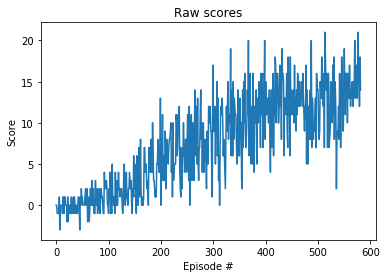

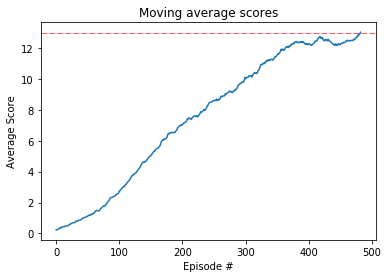

In [5]:
# helper function to generate moving average
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Raw scores")
plt.show()
fig.savefig('raw_scores_dqn.jpg', format='jpg')

avg_score = moving_average(scores, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(y=13., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)

plt.plot(np.arange(len(avg_score)), avg_score)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.title("Moving average scores")
plt.show()
fig.savefig('average_scores_dqn.jpg', format='jpg')

### 6. Play the trained agent

Now that we have a trained agent, we can reset the environment into non-training and then load the best weights for the DNN and run the agent through the Unity environment.

In [4]:
# reset the environment to get the state space 
env_info = env.reset(train_mode=False)[brain_name]

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

# create the agent 
agent = Agent(state_size=state_size, action_size=action_size, seed=0)


# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

#  run the agent three times
for i in range(3):
    score = 0
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]            # get the current state
    for j in range(1000):
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        
        if done:
            break 
    print('\rScore: {:.2f}'.format(score))
            

Score: 4.00
Score: -1.00
Score: 2.00


### 7. Close the environment

Once we are done, close the environment

In [7]:
env.close()


### Conclusion

Using a very standard and shallow DNN, we were able to solve the task in just over 400 episodes. 

This task seemed quite simple to solve with a basic DQN implementation. It seems that Dueling DQN or other enhancements would be overkill for this problem.
